In [1]:
from tensorflow import keras
from augmentation import *
from keras.utils import to_categorical
from keras import layers, optimizers
from keras.preprocessing.image import ImageDataGenerator
# import matplotlib.pyplot as plt
import tensorflow as tf

# %matplotlib inline


In [2]:
print(tf.config.list_physical_devices('GPU'))

[]


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values between 0 and 1
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Convert labels to one-hot encoding
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

167952384/170498071 [============================>.] - ETA: 0s

In [4]:
# Define CNN architecture
model = keras.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Conv2D(256, (3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.GlobalAvgPool2D(),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

learning_rate = 0.01
momentum = 0.09
mixup_alpha = 0.2
salt_pepper_amount = 0.06
batch_size = 256

sgd = optimizers.SGD(learning_rate, momentum)


# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 64)        0

In [5]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    # preprocessing_function=lambda img: add_salt_and_pepper_noise(img, 0.5, salt_pepper_amount),
    preprocessing_function=lambda img: cutout(img, 8)

)

train_data_generator = datagen.flow(x_train, y_train, batch_size=batch_size)


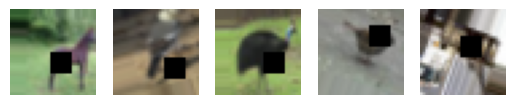

In [6]:
train_batch = datagen.flow(x_train, y_train, batch_size=5).next()

# Plot the first 5 images in the batch
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_batch[0][i])
    plt.axis('off')
plt.show()

In [7]:
# Train model
history = model.fit(train_data_generator, epochs=10, batch_size=batch_size, validation_data=(x_test, y_test))

# Evaluate model on test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/10
196/196 [==============================] - 125s 632ms/step - loss: 1.7472 - accuracy: 0.3545 - val_loss: 3.0165 - val_accuracy: 0.1429
Epoch 2/10
196/196 [==============================] - 124s 632ms/step - loss: 1.4741 - accuracy: 0.4657 - val_loss: 4.1798 - val_accuracy: 0.1712
Epoch 3/10
196/196 [==============================] - 124s 634ms/step - loss: 1.3626 - accuracy: 0.5097 - val_loss: 1.7330 - val_accuracy: 0.3915
Epoch 4/10
196/196 [==============================] - 124s 634ms/step - loss: 1.2858 - accuracy: 0.5394 - val_loss: 1.1483 - val_accuracy: 0.5956
Epoch 5/10
196/196 [==============================] - 124s 632ms/step - loss: 1.2273 - accuracy: 0.5629 - val_loss: 1.2440 - val_accuracy: 0.5657
Epoch 6/10
196/196 [==============================] - 123s 628ms/step - loss: 1.1727 - accuracy: 0.5832 - val_loss: 1.1689 - val_accuracy: 0.5932
Epoch 7/10
313/313 [==============================] - 7s 22ms/step - loss: 1.2517 - accuracy: 0.5895
Test accuracy: 0.589500

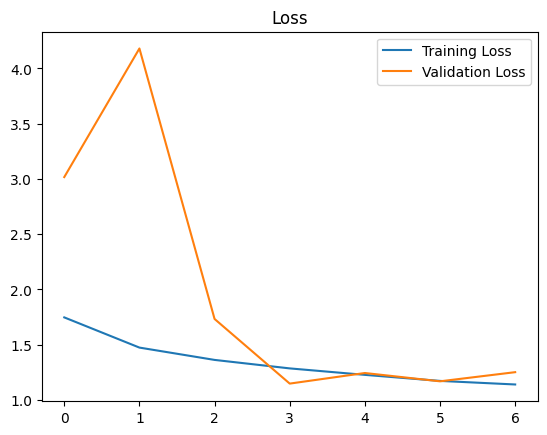

In [8]:
# Plot the training and validation loss on separate graphs
plt.subplot()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

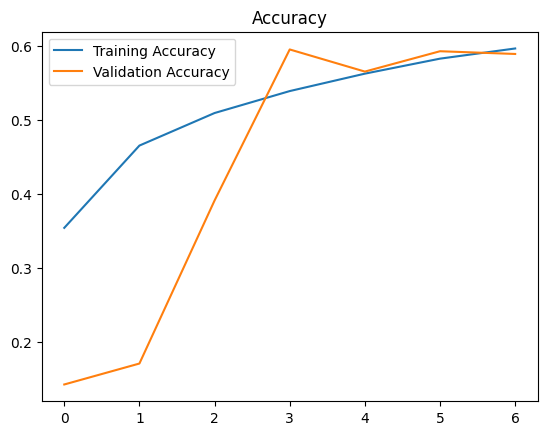

In [10]:
# Plot the training and validation accuracy on separate graphs
plt.subplot()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()